In [ ]:
# TBD: create bash script
# To download kssl dataset
# pip install gdown install --upgrade --no-cache-dir gdown

# cd /root
# python
# import gdown
# Links: 
#   - VNIR LUCAS: "1OnwGgDqvjnDYEik14h_lSi83M4AwzYBt"
#   - VNIR KSSL: "17ZNSqsQi6PUeOLnUozq-C6Pj22dItm_Y"
# id = "1qh8isMQIzhArsj3RNWJe6g0lx_cs7iBG" # MIRS KSSL v1 or "1SzQZqpbJuK3iCqjJYabuEobbgPXm3cHT" for v2
# gdown.download(id=id)
# quit()
# tar -xvf kssl.tar.gz

# paperspace only
#!pip install gdown 
#!pip install --upgrade gdown

In [ ]:
#!pip install spanda

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path
from datetime import datetime


from fastai.vision.all import *
from fastai.data.all import *
from tqdm import tqdm
import timm
from sklearn.metrics import r2_score

from spanda.data.transforms import (SpectraBlock, AnalytesBlock, Analytes, SpectraTfm, 
                                    TrimTfm, AnalytesTfm, SNVTfm, RandWAvgTfm, AvgTfm, GADFTfm, 
                                    To3DTfm, ResizeTfm, LogTfm)

use_cuda = torch.cuda.is_available()
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'


import warnings
warnings.filterwarnings('ignore')

## Utilities

In [ ]:
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

In [ ]:
def get_paths(src_dir, analytes=['725']):     
    path = Path(src_dir)
    
    # Only samples with spectra
    paths = [p for p in tqdm(path.ls()) if len(p.ls()) > 1]
    
    # Only strictly positive measurements
    paths = [p for p in tqdm(paths) if AnalytesTfm(analytes=analytes)(get_target(p)) > 0] 
    
    return L(paths)

In [ ]:
def get_dls(paths, analytes=['725'], seed=42):
    get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
    get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

    dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=analytes)),
                       get_x=get_spectra,
                       get_y=get_target,
                       splitter=RandomSplitter(valid_pct=0.2, seed=seed),
                       item_tfms=[AvgTfm(), SNVTfm(),
                                  LogTfm])
    return dblock.dataloaders(paths_all, bs=32, num_workers=6)

In [ ]:
current_date = lambda: datetime.now().date().isoformat()

## Data loading

In [ ]:
analytes = ['725'] # Kex

In [ ]:
paths_kssl = get_paths('../../_data/kssl-vnir', analytes=analytes)

100%|████████████████████████████████████████████████████████| 20949/20949 [00:15<00:00, 1331.37it/s]


In [ ]:
paths_lucas = get_paths('../../_data/lucas-vnir', analytes=analytes)

100%|████████████████████████████████████████████████████████| 21782/21782 [00:16<00:00, 1321.91it/s]


In [ ]:
paths_all = paths_kssl + paths_lucas; paths_all

(#42728) [Path('../../_data/kssl-vnir/163161'),Path('../../_data/kssl-vnir/110493'),Path('../../_data/kssl-vnir/97322'),Path('../../_data/kssl-vnir/166413'),Path('../../_data/kssl-vnir/92650'),Path('../../_data/kssl-vnir/47957'),Path('../../_data/kssl-vnir/170576'),Path('../../_data/kssl-vnir/120206'),Path('../../_data/kssl-vnir/42419'),Path('../../_data/kssl-vnir/78584')...]

## Train & evaluate

## Train KSSL | Eval on KSSL & LUCAS

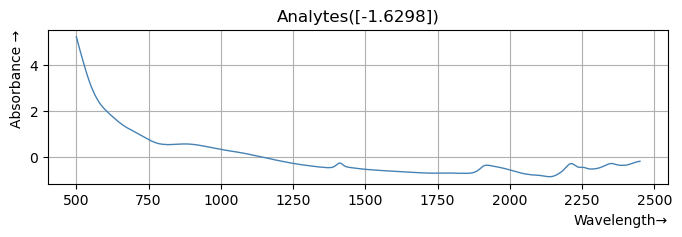

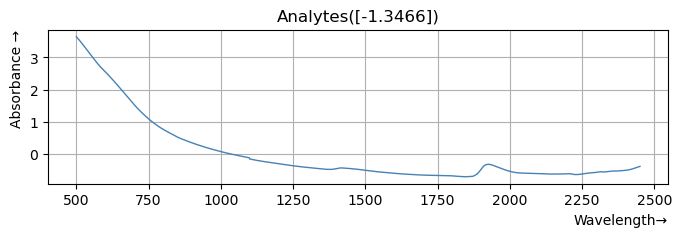

In [ ]:
dls = get_dls(paths_kssl)
dls.show_batch(max_n=2)

In [ ]:
# Create Learner
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=R2Score())

SuggestedLRs(valley=0.0004786300996784121)

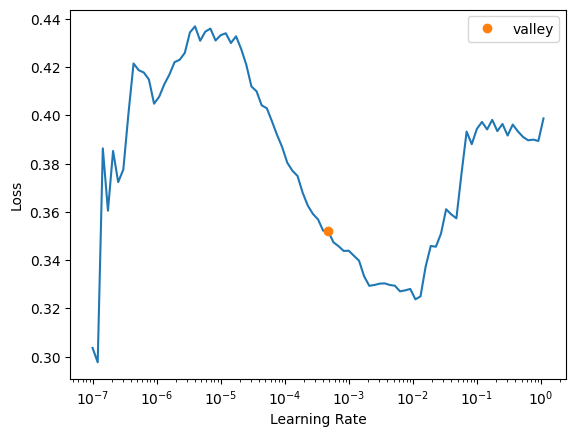

In [ ]:
learn.lr_find()

In [ ]:
# params
lr = 1e-3
epochs = 20

In [ ]:
# to do
# fit
# save model
# evaluate load model
# save metrics
learn.fit_one_cycle(40, 5e-4)

epoch,train_loss,valid_loss,r2_score,time
0,0.205711,0.193709,0.185840,00:26
1,0.192982,0.203334,0.145384,00:27
2,0.181197,0.181589,0.236780,00:26
3,0.183489,0.173340,0.271450,00:26
4,0.184950,0.184100,0.226225,00:27
5,0.180844,0.225505,0.052202,00:27
6,0.172236,0.194325,0.183251,00:27
7,0.159003,0.638735,-1.684610,00:27
8,0.163752,0.162530,0.316885,00:27
9,0.149106,0.161757,0.320136,00:27


In [ ]:
model_name = f'xresnet18-kex-nirs-kssl-{epochs}-epochs-lr-{lr:.1e}-r2-0.x-{get_date()}'; model_name

'xresnet18-kex-nirs-kssl-20-epochs-lr-1.0e-03-r2-0.x-2023-06-12'

In [ ]:
learn.save('xresnet18-kex-nirs-kssl-40-epochs-lr-5e4-r2-0.x-070623')

Path('models/xresnet18-kex-nirs-kssl-40-epochs-lr-1e3-r2-0.724-070623.pth')

In [ ]:
# Pre-trained model (KSSL)
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=R2Score())

weights_paths = '../../_data/models/xresnet18-kex-nirs-kssl-40-epochs-lr-1e3-r2-0.724-070623.pth'
xresnet_dict = torch.load(weights_paths, map_location=torch.device('cpu')) 
model.load_state_dict(xresnet_dict['model'])

<All keys matched successfully>

In [ ]:
dls_kssl = get_dls(paths_kssl)
dls_lucas = get_dls(paths_lucas)

In [ ]:
preds_kssl, targs_kssl = learn.get_preds(dl=dls_kssl.valid)
preds_lucas, targs_lucas = learn.get_preds(dl=dls_lucas.valid)

In [ ]:
preds_kssl.shape

torch.Size([8545, 1])

In [ ]:
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error)

In [ ]:
targs_kssl.squeeze()

tensor([-0.5202, -0.2356, -1.6265,  ..., -0.4708,  0.0519, -0.9509])

In [ ]:
r2_score(targs_kssl, preds_kssl)

0.46322491551140144

In [ ]:
r2_score(targs_lucas, preds_lucas)

0.46322491551140144